## Random Forest
Random Forests are an ensemble learning method that builds many decision trees and averages their predictions. They can capture non-linear relationships and are relatively robust to overfitting when tuned properly. They serve as a strong baseline and are useful for comparison with deep learning approaches or other classical models like logistic regression and SVM.

In [3]:
#############################################
# Chunk 1: Imports, Seeds, and Setup
#############################################
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

#############################################
# Chunk 2: Data Collection and Label Encoding
#############################################
def get_image_paths_and_labels(directory):
    file_paths = []
    labels = []
    # List subdirectories (each class) in sorted order
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        for file in os.listdir(cls_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(cls_dir, file))
                labels.append(cls)
    return pd.DataFrame({'file_path': file_paths, 'label': labels})

# Define the copied training directory (adjust path as needed)
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')
df = get_image_paths_and_labels(new_train_dir)
print("Sample image paths and labels:")
print(df.head())

# Encode labels into numerical values
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

Sample image paths and labels:
                                           file_path      label
0  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
1  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
2  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
3  intel_dataset_copy/seg_train/seg_train/buildin...  buildings
4  intel_dataset_copy/seg_train/seg_train/buildin...  buildings


In [4]:
#############################################
# Chunk 3: Feature Extraction using MobileNetV2
#############################################
# Load MobileNetV2 pre-trained on ImageNet without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
# Create a feature extractor using Global Average Pooling
gap = GlobalAveragePooling2D()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=gap)

def extract_features(file_path, target_size=(150,150)):
    img = load_img(file_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = feature_extractor.predict(img_array, verbose=0)
    return features.flatten()

# Extract features for all images using a progress bar
features = []
for path in tqdm(df['file_path'], desc="Extracting features"):
    feat = extract_features(path)
    features.append(feat)
features = np.array(features)
print("Extracted features shape:", features.shape)

#############################################
# Chunk 4: Feature Scaling
#############################################
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

/var/folders/jk/60n1sr0j45ggchrdnrr6vts00000gn/T/ipykernel_2753/3442356783.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
Extracting features: 100%|████████████████████████████████████| 14016/14016 [13:39<00:00, 17.11it/s]


Extracted features shape: (14016, 1280)


In [5]:
#############################################
# Chunk 5: K-Fold Splitting and Random Forest Training with Hyperparameter Tuning
#############################################
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
folds = list(skf.split(features_scaled, df['label_encoded']))
print(f"Total number of folds: {len(folds)}")

fold_f1_scores = []
fold_reports = []

fold_number = 1
for train_idx, test_idx in folds:
    print(f"\n--- Fold {fold_number} ---")
    X_train, X_test = features_scaled[train_idx], features_scaled[test_idx]
    y_train, y_test = df['label_encoded'].values[train_idx], df['label_encoded'].values[test_idx]
    
    # Define a Random Forest classifier with hyperparameter tuning
    rf_model = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    
    grid = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print("Best parameters for fold", fold_number, ":", grid.best_params_)
    y_pred = grid.predict(X_test)
    fold_f1 = f1_score(y_test, y_pred, average='weighted')
    print("Fold", fold_number, "Weighted F1 Score:", fold_f1)
    fold_f1_scores.append(fold_f1)
    
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print("Fold", fold_number, "Classification Report:\n", report)
    fold_reports.append(report)
    
    fold_number += 1

avg_f1 = np.mean(fold_f1_scores)
print("\nAverage Weighted F1 Score across folds:", avg_f1)

Total number of folds: 5

--- Fold 1 ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for fold 1 : {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Fold 1 Weighted F1 Score: 0.9000637602360436
Fold 1 Classification Report:
               precision    recall  f1-score   support

   buildings       0.92      0.92      0.92       438
      forest       1.00      0.97      0.98       454
     glacier       0.81      0.83      0.82       481
    mountain       0.88      0.82      0.85       501
         sea       0.92      0.94      0.93       454
      street       0.90      0.93      0.91       476

    accuracy                           0.90      2804
   macro avg       0.90      0.90      0.90      2804
weighted avg       0.90      0.90      0.90      2804


--- Fold 2 ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for fold 2 : {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Fold 2 Weighted 

[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  21.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time= 1.5min
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  47.8s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  18.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  36.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  37.7s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=  18.1s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=  38.8s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time= 1.3min
[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time= 1.6min
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  45.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  25.1s
[CV] END max_depth=Non

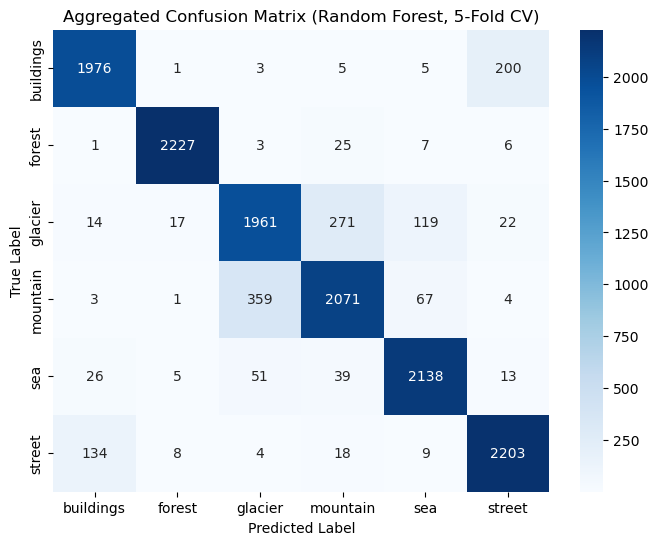

In [6]:
#############################################
# Chunk 6: Aggregated Confusion Matrix for K-Fold Evaluation (Optional)
#############################################
from sklearn.metrics import confusion_matrix
all_y_true = []
all_y_pred = []

# Get aggregated predictions using cross_val_predict approach if desired:
from sklearn.model_selection import cross_val_predict
# Using RandomForest with best parameters from one fold as a baseline for aggregated evaluation:
rf_model_cv = RandomForestClassifier(**grid.best_params_, random_state=42)
all_y_pred = cross_val_predict(rf_model_cv, features_scaled, df['label_encoded'].values, cv=5)
all_y_true = df['label_encoded'].values

cm_rf = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Aggregated Confusion Matrix (Random Forest, 5-Fold CV)')
plt.show()

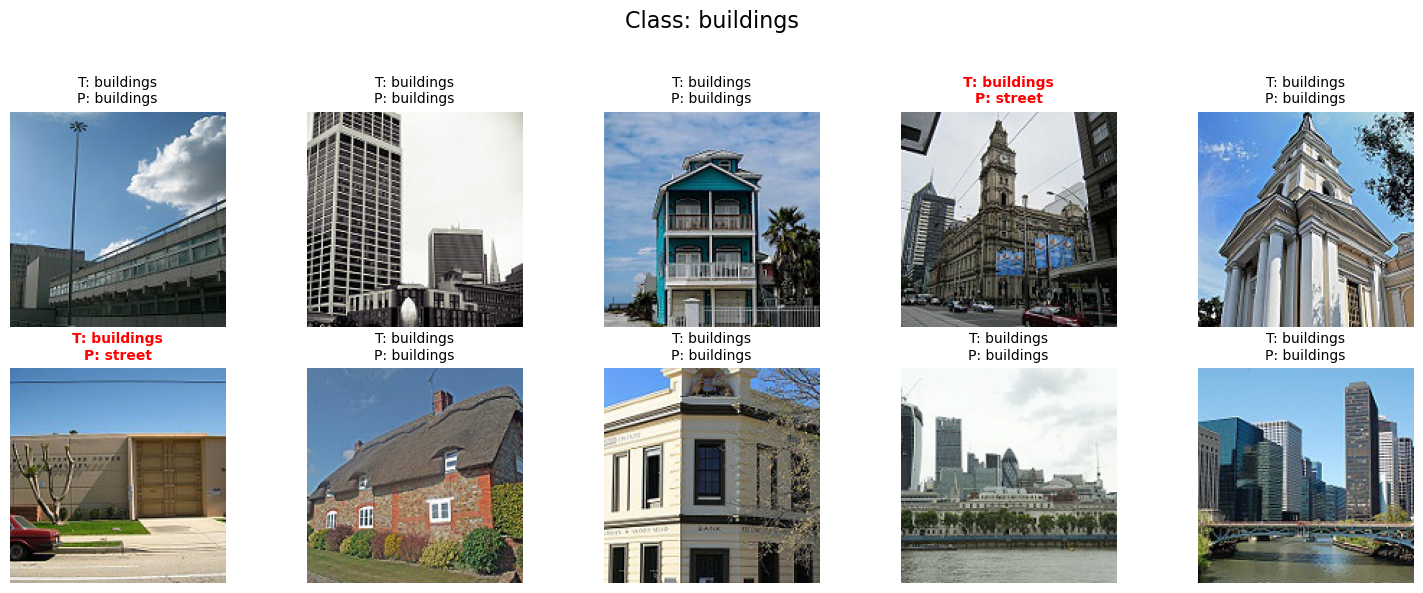

--------------------------------------------------------------------------------


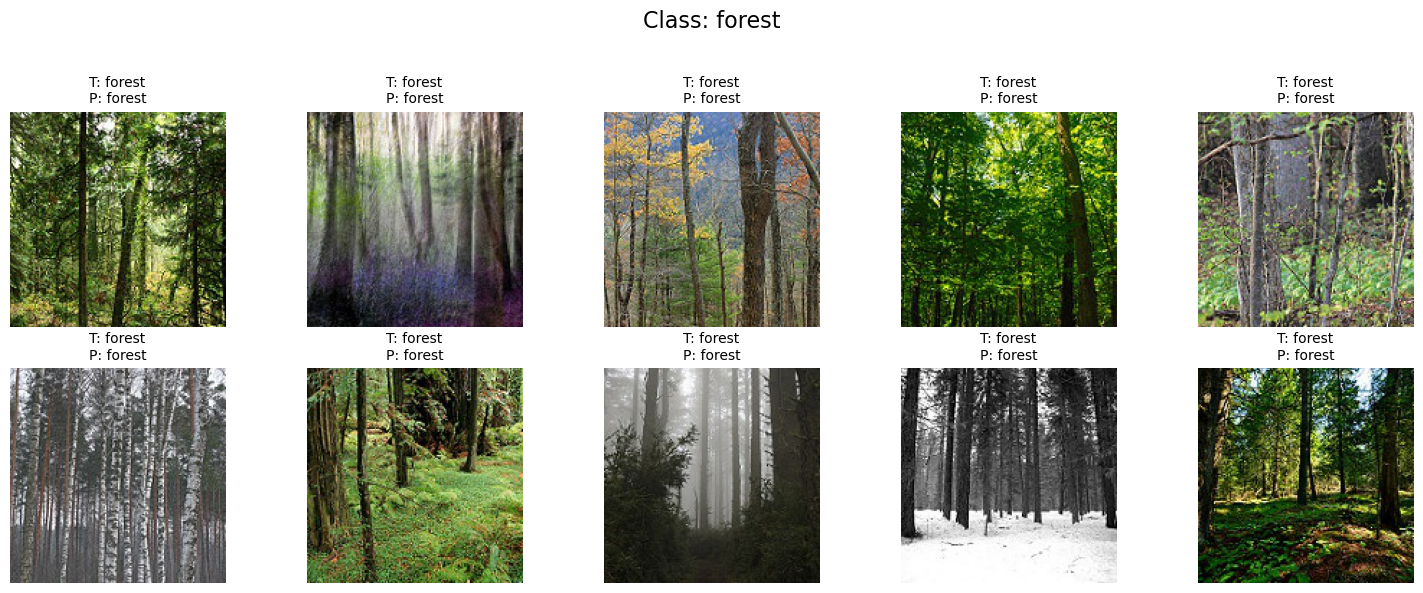

--------------------------------------------------------------------------------


In [ ]:
#############################################
# Chunk 7: Visualization of Random Forest Predictions on Test Set Images
#############################################
from tensorflow.keras.preprocessing.image import load_img

def display_rf_predictions(num_images=10, rows=2, cols=5, target_size=(150,150)):
    # Set random seed for reproducibility
    random.seed(42)
    
    # Define the copied test directory
    new_test_dir = os.path.join('intel_dataset_copy', 'seg_test', 'seg_test')
    # Get sorted list of classes from the test directory
    classes = sorted([d for d in os.listdir(new_test_dir) if os.path.isdir(os.path.join(new_test_dir, d))])
    
    for cls in classes:
        class_dir = os.path.join(new_test_dir, cls)
        # Get sorted list of image files in this class
        images = sorted([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        # Randomly select up to num_images images
        selected = random.sample(images, min(num_images, len(images)))
        
        # Create subplots: grid of rows x cols for current class
        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        fig.suptitle(f"Class: {cls}", fontsize=16)
        axes = axes.flatten()
        
        for ax, img_file in zip(axes, selected):
            img_path = os.path.join(class_dir, img_file)
            # Load the image (resized for display)
            img = load_img(img_path, target_size=target_size)
            # Extract features and scale them
            feat = extract_features(img_path, target_size=target_size)
            feat_scaled = scaler.transform(feat.reshape(1, -1))
            # Predict the label using the Random Forest model from cross_val_predict baseline (or use grid.best_estimator_ if preferred)
            pred_encoded = rf_model_cv.fit(features_scaled, df['label_encoded'].values).predict(feat_scaled)[0]
            pred_class = le.inverse_transform([pred_encoded])[0]
            true_class = cls
            
            title_text = f"T: {true_class}\nP: {pred_class}"
            if pred_class != true_class:
                ax.set_title(title_text, fontweight='bold', color='red', fontsize=10)
            else:
                ax.set_title(title_text, fontsize=10)
            ax.imshow(img)
            ax.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        print("-" * 80)

# Display predictions for 10 images per class (2 rows x 5 columns)
display_rf_predictions(num_images=10, rows=2, cols=5, target_size=(150,150))